In [1]:
# from dotenv import load_dotenv 

# Load environment variables from .env
# load_dotenv()

In [2]:
from src import utility_functions
import pandas as pd 
import sklearn 
from pathlib import Path
import json
from kaggle.api.kaggle_api_extended import KaggleApi
import numpy as np 
import matplotlib.pyplot as plt 
import re
from wordcloud import WordCloud

In [3]:

# Authenticate after setting up the dotfile inside .kaggle/ dotfile in /home/{username}/
api = KaggleApi()
api.authenticate()

# Set the dataset name and destination directory
dataset_name = 'rounakbanik/the-movies-dataset'
destination_dir = Path('the_movies_dataset')

# Download the dataset if file exists
if destination_dir.is_dir():
    print("Directory already exists!")
else:
    api.dataset_download_files(dataset_name, path=destination_dir, unzip=True)

Directory already exists!


In [4]:
absolute_path = Path("the_movies_dataset")
file_names = [file_path for file_path in absolute_path.glob('*.*')]
file_names

[PosixPath('the_movies_dataset/README.html'),
 PosixPath('the_movies_dataset/ratings_small.csv'),
 PosixPath('the_movies_dataset/ratings.csv'),
 PosixPath('the_movies_dataset/links_small.csv'),
 PosixPath('the_movies_dataset/credits.csv'),
 PosixPath('the_movies_dataset/keywords.csv'),
 PosixPath('the_movies_dataset/links.csv'),
 PosixPath('the_movies_dataset/movies_metadata.csv')]

In [5]:
ratings_small = pd.read_csv(absolute_path / "ratings_small.csv")
ratings = pd.read_csv(absolute_path / "ratings.csv")
links_small = pd.read_csv(absolute_path / "links_small.csv")
credits = pd.read_csv(absolute_path / "credits.csv")
keywords = pd.read_csv(absolute_path / "keywords.csv")
links = pd.read_csv(absolute_path / "links.csv")
movies_metadata = pd.read_csv(absolute_path / "movies_metadata.csv")

/tmp/ipykernel_270352/3104030712.py:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_metadata = pd.read_csv(absolute_path / "movies_metadata.csv")


In [6]:
movies_metadata.head(2).T

,0,1
adult,False,False
belongs_to_collection,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN
budget,30000000,65000000
genres,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
homepage,http://toystory.disney.com/toy-story,NaN
id,862,8844
imdb_id,tt0114709,tt0113497
original_language,en,en
original_title,Toy Story,Jumanji
overview,"Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...


In [7]:
movies_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

# Data Preprocessing

## Variable transformation

##### Release date cast into datetime, popularity cast into int

In [8]:
movies_metadata["release_date"] = pd.to_datetime(movies_metadata["release_date"], errors='coerce')

In [9]:
# This column has a mix of floats and natural strings, the conversion fails:
failed_conversions_id = movies_metadata["popularity"][pd.to_numeric(movies_metadata["popularity"], errors='coerce').isna()].index

In [10]:
# # [0] here means I am adding for the visual inspection one column that I believe to be standard
# # From the visual inspection some columns have completely mixed values e.g., index 29503, 35587, 19730 these will be dropped 
# # index 19729, 29502, 35586 seem to be ok even though they have a lot of missing values, the NAs they contain will be coerced during conversion
movies_metadata.iloc[[0] + failed_conversions_id.tolist()].T;

In [11]:
movies_metadata = movies_metadata.drop(index=[29503, 35587, 19730])
movies_metadata["popularity"] = pd.to_numeric(movies_metadata["popularity"], errors='coerce')
movies_metadata = movies_metadata.astype({"id": int})

#### Duplicate Rows found

In [12]:
# Here we are visualizing the duplicate columns that exist, no need for them for our analysis by visualizing inspection we can safely keep one
# Note: here we are grabbing two most unique indices that will help us identify and sort them so duplcate rows can be better visualized.
movies_metadata[movies_metadata.duplicated(keep=False)].set_index(["popularity","imdb_id"]).sort_index();

In [13]:
movies_metadata = movies_metadata.drop_duplicates(keep="first")

##### Original Title Inspection

In [14]:
# A significant amount of movies have duplicated original_titles...

print(f"Length of original_title: {len(movies_metadata.original_title)}\nNumber of unique original_title: {movies_metadata.original_title.nunique()}")

Length of original_title: 45446
Number of unique original_title: 43371


In [15]:
print(movies_metadata.shape)
print(movies_metadata[movies_metadata.duplicated(subset=["original_title"])].shape)

(45446, 24)
(2075, 24)


In [16]:
# From a brief visual inspection I saw that some of those duplicated movies have no budget listed for them
# We will pick the ones with a listed budget (we assume no listed budget is budget = 0)

# Around 50% have a different budget we will pick the record with the higher updated budget (this is an assumption)
print(movies_metadata[movies_metadata.duplicated(subset=["original_title", "budget"])].shape)

(1193, 24)


In [17]:
print("original title and budget number of duplicates:")
print(movies_metadata[movies_metadata.duplicated(subset=["original_title", "budget"], keep=False)].shape[0])
print("original title duplicates:")
print(movies_metadata[movies_metadata.duplicated(subset=["original_title"], keep=False)].shape[0])

original title and budget number of duplicates:
2171
original title duplicates:
3725


In [18]:
# Here the filtering is done we will pick based on the budget first (from Highest) and then if the budget is tied the most popular movie
# will be picked, and etc.. 

sorted_df = movies_metadata.sort_values(by=["budget", "popularity", "vote_count", "vote_average"], ascending=False)

# check everything is done properly
# sorted_df[sorted_df.duplicated(subset=["original_title", "budget"], keep=False)].set_index(["original_title", "budget"]);

movies_metadata = sorted_df.drop_duplicates(subset=["original_title"], keep='first')


del(sorted_df)

In [19]:
print("original title duplicates:")
print(movies_metadata[movies_metadata.duplicated(subset=["original_title"], keep=False)].set_index(["original_title"]).shape[0])

original title duplicates:
0


In [20]:
movies_metadata.reset_index(drop=True, inplace=True)

##### Vote Count Inspection

In [21]:
# Check if it vote_count which is a count variable (should be an integer) can be cast to an int:
print(movies_metadata["vote_count"].astype(str).str.match(r'.*[1-9]$').any())

# Does it have NAs? 
print(movies_metadata["vote_count"][movies_metadata["vote_count"].isna()])

# Nothing to do here, floats can't be casted to integers if there are NAs

False
43369   NaN
43370   NaN
Name: vote_count, dtype: float64


#### Fix the IDs 

In [22]:
# there are dates inside ids 
movies_metadata["id"][pd.to_numeric(movies_metadata["id"], errors="coerce").isna()]

Series([], Name: id, dtype: int64)

In [23]:
# Just in case check if it needs float conversion or int conversion
print(movies_metadata["budget"].astype(str).str.contains('\.').any().any())
movies_metadata = movies_metadata.astype({"budget": int})

False


##### Release date cast into datetime, popularity cast into int

In [24]:
movies_metadata["release_date"] = pd.to_datetime(movies_metadata["release_date"], errors='coerce')

In [25]:
# This column has a mix of floats and natural strings, the conversion fails:
failed_conversions_id = movies_metadata["popularity"][pd.to_numeric(movies_metadata["popularity"], errors='coerce').isna()].index

In [26]:
# # [0] here means I am adding for the visual inspection one column that I believe to be standard
# # From the visual inspection some columns have completely mixed values e.g., index 29503, 35587 these will be dropped 
# # index 19729, 29502, 35586 seem to be ok even though they have a lot of missing values, the NAs they contain will be coerced during conversion
movies_metadata.iloc[[0] + failed_conversions_id.tolist()].T;

In [27]:
movies_metadata = movies_metadata.drop(index=[29503, 35587])
movies_metadata["popularity"] = pd.to_numeric(movies_metadata["popularity"], errors='coerce')
movies_metadata = movies_metadata.astype({"id": int})

# Visualize the target variables

### Visualizes the Budget

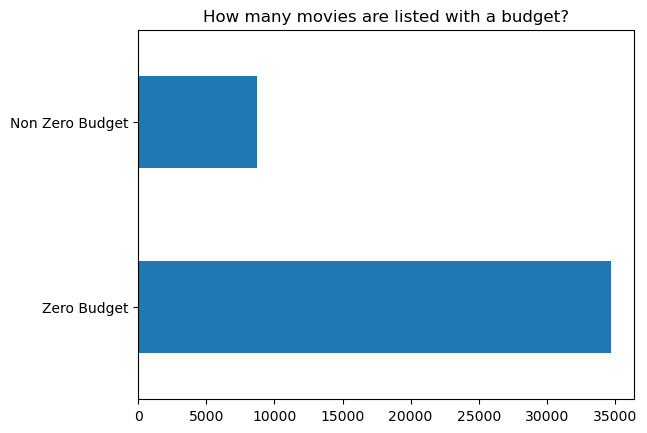

In [28]:
# how many movies have a budget that is not equal to 0, we will assume if the budget is 0 that this movie is not posting its budget publicly
# we could perhaps use it for forecasting
movies_metadata["budget"].map(lambda x: "Non Zero Budget" if x>0 else "Zero Budget")\
    .value_counts().plot(kind="barh", title="How many movies are listed with a budget?");

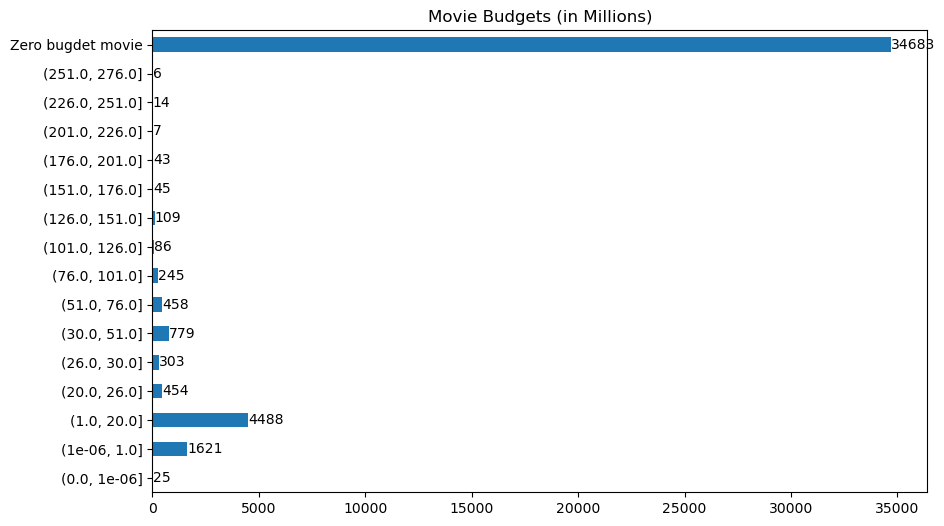

In [29]:
# Discretionize the continuous variable budget
# Note: This was an iterative process to find the best binning

non_zero_budget = movies_metadata["budget"][movies_metadata["budget"] > 0].div(1e6)
budget_movie_count = (
    movies_metadata["budget"][movies_metadata["budget"] == 0]
    .value_counts()
    .rename(index={0: "Zero bugdet movie"})
)

ax = pd.concat(
    [
        pd.cut(
            non_zero_budget,
            bins=sorted(np.concatenate((np.arange(1, 300, 25), [1e-6, 0, 20, 30]))),
        )
        .value_counts()
        .sort_index(),
        budget_movie_count,
    ]
).plot(kind="barh", title="Movie Budgets (in Millions)", figsize=(10, 6))

ax.bar_label(ax.containers[0], fmt="%d", label_type="edge")
plt.title("Movie Budgets (in Millions)")
plt.show()

### Visualizes the movie votes

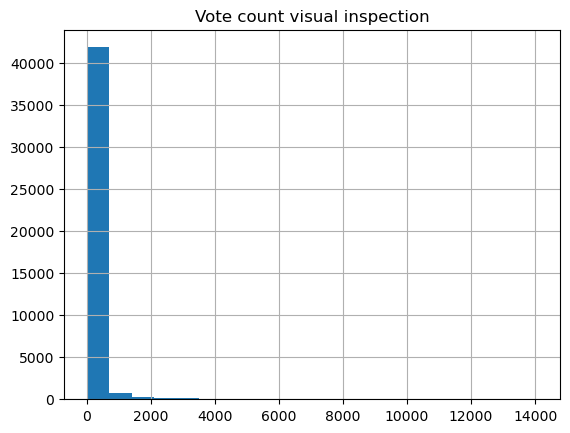

In [30]:
movies_metadata["vote_count"].hist(bins=20).set_title("Vote count visual inspection");

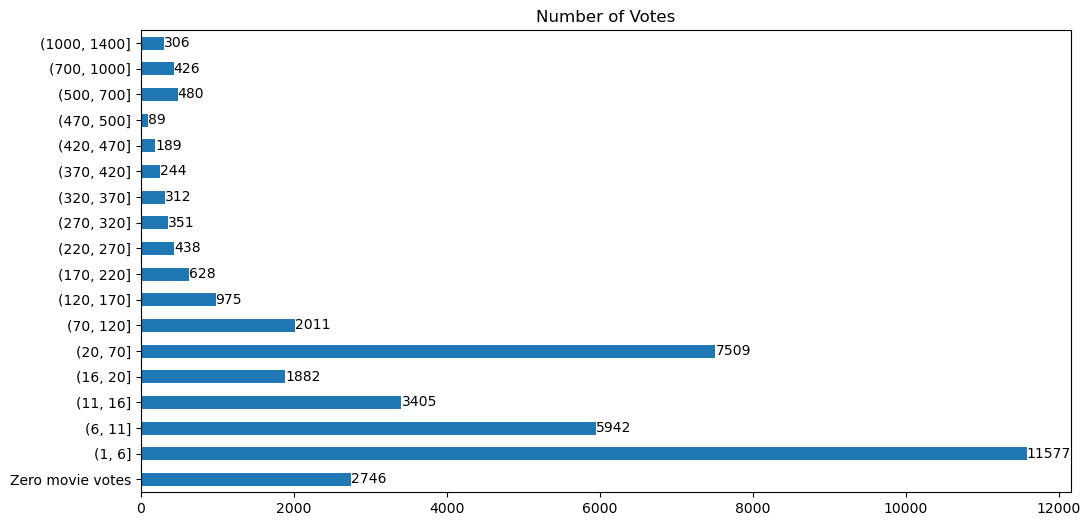

In [31]:
# Most of the movies appear to have a low amount of votes
zero_movie_votes = (
    movies_metadata["vote_count"][movies_metadata["vote_count"] == 0]
    .value_counts()
    .rename(index={0: "Zero movie votes"})
)

manually_defined_bins = np.concatenate(
    (
        np.arange(1, 20, 5),
        np.arange(20, 499, 50),
        np.array([500, 700, 1000, 1400]),
    )
)

ax = pd.concat(
    [
        zero_movie_votes,
        pd.cut(movies_metadata["vote_count"], bins=manually_defined_bins)
        .value_counts()
        .sort_index(),
    ]
).plot(kind="barh", figsize=(12, 6))

ax.bar_label(ax.containers[0], fmt="%d", label_type="edge")
plt.title("Number of Votes")
plt.show()

### Vote Average distribution

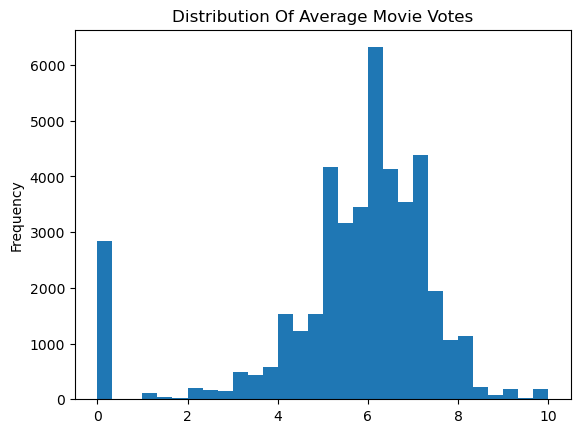

In [32]:
# TODO: Suspicious amount of 0 inflated ratings, need to investigate further
movies_metadata["vote_average"].plot(kind="hist", bins=30, title="Distribution Of Average Movie Votes");

### Distribution of Revenue

In [33]:
print("Percentage of movies that have a revenue that is listed:")
print(np.round((movies_metadata["revenue"].fillna(0) > 0).sum() / (movies_metadata["revenue"].fillna(0)==0).sum()*100,2))

Percentage of movies that have a revenue that is listed:
19.88


#### Small checks 

In [34]:
movies_metadata["tagline"].isna().value_counts()

True     23997
False    19372
Name: tagline, dtype: int64

In [35]:
movies_metadata["overview"].isna().value_counts()

False    42439
True       930
Name: overview, dtype: int64

In [36]:
# Fill movies without an overview with an empty string for now
movies_metadata["overview"] = movies_metadata["overview"].fillna("")

### Check ratings_small how many matching IDs it has with movies_metadata

There are way too many missing ratings from users in ratings_small I will choose to ignore this dataset for now, of course many other visualizations can be made using it (e.g., descriptive type of statistics). 

Given the time constraint and the objective, which is defined at the bottom of this notebook. The aim will be to forecast ratings_average, and given that ratings_small has user ratings which are used to compute ratings_average, it needs to be discarded from the analysis. 

A case can be made about trying to predict what rating would a user give to a certain movie instead of trying to find what average rating the movie is going to get, though given the availability of the data I will opt for predicting ratings_average which seems to be much more complete. 

N.B. I also checked link.csv and it seems also to not have that many ratings in it 

In [37]:
ratings_small["timestamp"] = pd.to_datetime(ratings["timestamp"], unit='s')

In [38]:
print("Number of unique users:", ratings_small["userId"].nunique())

Number of unique users: 671


In [39]:
print(f"Number of common movie IDs: {len(set(ratings_small['movieId']).intersection(set(movies_metadata['id'])))}")
print(f"Number of missing movie IDs: {len(set(ratings_small['movieId']).difference(set(movies_metadata['id'])))}")
print(f"Total unique movie IDs:", ratings_small["movieId"].nunique())

Number of common movie IDs: 2705
Number of missing movie IDs: 6361
Total unique movie IDs: 9066


In [40]:
movies_metadata.shape

(43369, 24)

#### Checks which movies have a description that is not in English

In [41]:
utility_functions.only_roman_chars(movies_metadata["overview"][0])

True

In [42]:
# latin_only_mask = movies_metadata["title"].fillna("AssertionError").apply(utility_functions.only_roman_chars)
# movies_metadata["title"][~latin_only_mask]

#### Make movies_metadata genres into JSON

In [43]:
movies_metadata["genres"] = movies_metadata["genres"].str.replace("'", "\"").apply(json.loads)

In [44]:
# Check how many empty lists are in the data
# we could maybe feature engineer a variable 
movies_metadata["genres"].apply(lambda x: len(x) == 0).value_counts()

False    41042
True      2327
Name: genres, dtype: int64

#### Extract movie genre

In [45]:
movies_metadata["movie_genre"] = movies_metadata["genres"].apply(lambda genre_list: [genre['name'] for genre in genre_list])

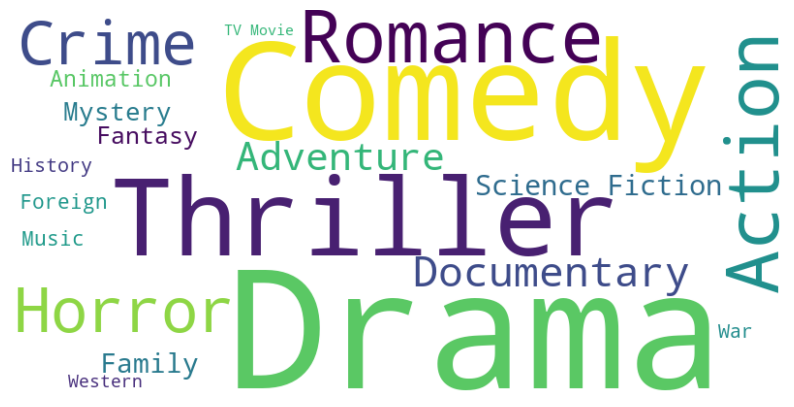

In [46]:
wordcloud_data = movies_metadata["movie_genre"].explode().value_counts()
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show();

#### Belongs to collection

In [47]:
# too many NAs we will just ignore this column
movies_metadata["belongs_to_collection"].isna().value_counts()

True     38975
False     4394
Name: belongs_to_collection, dtype: int64

#### Count number of common IDs that keywords has with movies_metadata

In [48]:
print(f"General shape of the dataframe Keywords: {keywords.shape}")
print(f"Number of common movie IDs: {len(set(keywords['id']).intersection(set(movies_metadata['id'])))}")
print(f"Number of missing movie IDs: {len(set(keywords['id']).difference(set(movies_metadata['id'])))}")
print(f"Total unique movie IDs:", keywords["id"].nunique())

General shape of the dataframe Keywords: (46419, 2)
Number of common movie IDs: 43368
Number of missing movie IDs: 2064
Total unique movie IDs: 45432


#### Process keywords to be convertible to JSON

In [49]:
keywords_processed = keywords["keywords"].apply(utility_functions.remove_apostrophes)

In [50]:
utility_functions.identify_unprocessed_rows(keywords_processed)

{41014: json.decoder.JSONDecodeError("Expecting ',' delimiter: line 1 column 118 (char 117)")}

In [51]:
# only one row to replace manually: 
keywords_processed[41014] = keywords_processed[41014].replace("operation \"trudy jackson", "operation trudy jackson")

In [52]:
# now we can load it with json.loads
keywords_processed = keywords_processed.apply(json.loads)

In [53]:
keywords_processed[2]

[{'id': 1495, 'name': 'fishing'},
 {'id': 12392, 'name': 'best friend'},
 {'id': 179431, 'name': 'duringcreditsstinger'},
 {'id': 208510, 'name': 'old men'}]

#### Spoken Languages

In [54]:
spoken_languages = (
    movies_metadata.fillna("{}")["spoken_languages"]
    .apply(utility_functions.remove_apostrophes)
    .str.replace(r"\\x9", "", regex=True)
)

In [55]:
spoken_languages[3377]

'[{"iso_639_1": "lt", "name": "Lietuvi akai"}, {"iso_639_1": "ru", "name": "Pусский"}, {"iso_639_1": "en", "name": "English"}]'

In [56]:
utility_functions.identify_unprocessed_rows(spoken_languages)

{29503: KeyError(29503), 35587: KeyError(35587)}

In [57]:
spoken_languages.apply(json.loads)  

0                     [{'iso_639_1': 'ja', 'name': '日本語'}]
1        [{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...
2                 [{'iso_639_1': 'en', 'name': 'English'}]
3                 [{'iso_639_1': 'en', 'name': 'English'}]
4        [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
                               ...                        
43366                                                   []
43367                                                   []
43368             [{'iso_639_1': 'en', 'name': 'English'}]
43369                                                   {}
43370                                                   {}
Name: spoken_languages, Length: 43369, dtype: object

#### Process Credits

In [58]:
print(f"General shape of the dataframe Credits: {credits.shape}")
print(f"Number of common movie IDs: {len(set(credits['id']).intersection(set(movies_metadata['id'])))}")
print(f"Number of missing movie IDs: {len(set(credits['id']).difference(set(movies_metadata['id'])))}")
print(f"Total unique movie IDs:", credits["id"].nunique())

General shape of the dataframe Credits: (45476, 3)
Number of common movie IDs: 43368
Number of missing movie IDs: 2064
Total unique movie IDs: 45432


The credits will take too much time to process using regular expressions:

In [59]:
# cast = (
#     credits["cast"]
#     .apply(utility_functions.remove_apostrophes)
#     .str.replace("None", '""')
# )
# utility_functions.remove_apostrophes(credits["cast"][70])[1800:1909] # 70 corresponds to the first row listed in:
#  utility_functions.identify_unprocessed_rows(cast)

Therefore I will have to evaluate the string as literal to be able to proceed*. 
There are many other ways of doing it you could for instance regex grouped matching by specifying the key: value relationship and extracting the lead of the movie and etc..., For example, if the group is a key from the JSON, say we pick "name:" then we can capture what is in the next group by saying its matched content is surrounded by double or single quotes, repeat until you have captured all the entities from the malformed JSON.

*Note: This should never be used in production direct string evaluation is a known vulnerability, one exploit would be to modify the data sources with malicious code that will be executed as literal Python code. 

In [60]:
import ast
cast = credits["cast"].apply(ast.literal_eval)

In [61]:
# We will only take the name of the actors 
actors = cast.apply(lambda cast_list: [item['name'] for item in cast_list]).rename("actors")

In [62]:
number_of_actors = actors.apply(len)

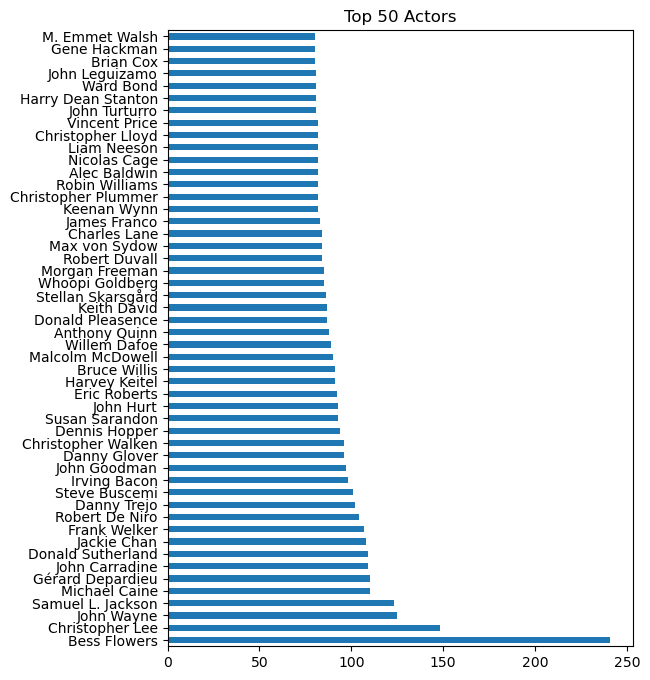

In [63]:
actors.explode().value_counts().head(50).plot(kind="barh", figsize=(6,8), title="Top 50 Actors");

#### One Hot Encode the Actors

In [64]:
top_15_actors = set(actors.explode().value_counts().head(15).index)
reduced_actors = actors.apply(set).apply(
    lambda all_actors: list(all_actors.intersection(top_15_actors)) or []
)

In [65]:
reduced_actors_oh = pd.get_dummies(reduced_actors.explode(), columns=['Actors'], prefix='Actors').groupby(level=0).sum()

In [66]:
# check if the one hot encoding indeed produced the right results and there is no value not in between [0,1] for a given column:
((reduced_actors_oh == 0) | (reduced_actors_oh == 1)).all().any()

True

In [67]:
credits_final = pd.concat([credits["id"], reduced_actors_oh, number_of_actors], axis=1)

#### One Hot Encode the Keywords Data

In [68]:
keywords.shape

(46419, 2)

In [69]:
keywords_processed[0][0]

{'id': 931, 'name': 'jealousy'}

In [70]:
filtered_keywords = keywords_processed.apply(lambda cast_list: [item['name'] for item in cast_list])

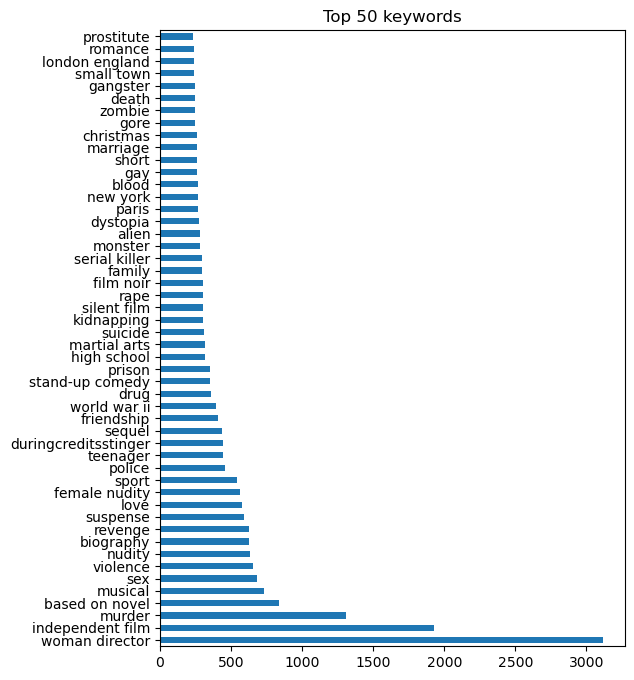

In [71]:
filtered_keywords.explode().value_counts().head(50).plot(kind="barh", figsize=(6,8), title="Top 50 keywords");

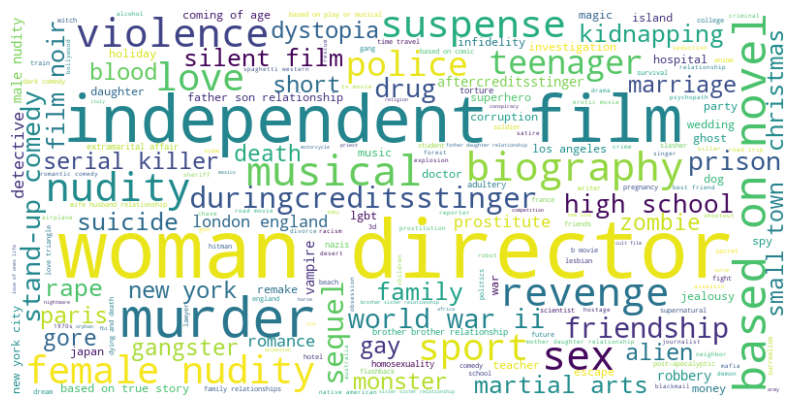

In [72]:
wordcloud_data = filtered_keywords.explode().value_counts()
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show();

In [73]:
top_20_keywords = set(filtered_keywords.explode().value_counts().head(20).index)
reduced_keywords = filtered_keywords.apply(set).apply(
    lambda all_keywords: list(all_keywords.intersection(top_20_keywords)) or []
)

In [74]:
reduced_keywords.value_counts()

[]                                                                34339
[woman director]                                                   2513
[independent film]                                                 1257
[musical]                                                           613
[murder]                                                            590
                                                                  ...  
[teenager, sport, based on novel, sex]                                1
[based on novel, revenge, love, murder, independent film]             1
[based on novel, sequel, violence, suspense]                          1
[violence, woman director, murder, suspense, independent film]        1
[violence, murder, female nudity]                                     1
Name: keywords, Length: 672, dtype: int64

In [111]:
reduced_keywords_oh = pd.get_dummies(reduced_keywords.explode(), columns=['Keywords'], prefix='Keywords').groupby(level=0).sum()

In [76]:
# check if the one hot encoding indeed produced the right results and there is no value not in between [0,1] for a given column:
((reduced_keywords_oh == 0) | (reduced_keywords_oh == 1)).all().any()

True

In [77]:
final_keywords_df = pd.concat([keywords["id"], reduced_keywords_oh, number_of_actors], axis=1)
final_keywords_df.shape

(46419, 22)

### Prepare movie_genre for analysis

In [78]:
spoken_languages = spoken_languages.apply(json.loads)

##### See all the keys that are contained in the spoken languages dict

In [79]:
spoken_languages.apply(lambda lang_list: [item.keys() for item in lang_list]).explode().value_counts()

(iso_639_1, name)    51050
Name: spoken_languages, dtype: int64

We can capture the names by using iso_639_1

In [80]:
# lets convert it into the number of different spoken languages that the movie has
# we could create a one hot encoding matrix of all the different languages but its demands too much RAM
num_spoken_lang = spoken_languages.apply(
    lambda lang_list: [item["iso_639_1"] for item in lang_list]
).apply(len)

In [81]:
num_spoken_lang = num_spoken_lang.astype("category")

In [82]:
# No more processing needed, this can be one hot encoded
movies_metadata["movie_genre"].explode().value_counts()

Drama              19207
Comedy             12771
Thriller            7148
Romance             6375
Action              6292
Horror              4376
Crime               4070
Documentary         3820
Adventure           3315
Science Fiction     2893
Family              2622
Mystery             2330
Fantasy             2170
Animation           1881
Foreign             1562
Music               1524
History             1338
War                 1272
Western              995
TV Movie             687
Name: movie_genre, dtype: int64

In [83]:
movie_genre_oh = pd.get_dummies(movies_metadata["movie_genre"].explode(), columns=['movie_genre'], prefix="Genre").groupby(level=0).sum()

In [84]:
# check if the one hot encoding indeed produced the right results and there is no value not in between [0,1] for a given column:
((movie_genre_oh == 0) | (movie_genre_oh == 1)).all().any()

True

In [85]:
movies_metadata = movies_metadata.drop(columns="movie_genre")

In [86]:
movies_metadata = movies_metadata.astype(
    {
        col: "category"
        for col in ["adult", "status", "original_language", "status", "video"]
    }
)

In [87]:
# I haven't had time to adjust parametere of TF-IDF, in general the idea would be to pick a certain min_df + max_df
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = movies_metadata["overview"].to_list()
vectorizer = TfidfVectorizer(min_df=20, stop_words="english", max_features=50)
X = vectorizer.fit_transform(corpus)
top_features = vectorizer.get_feature_names_out()
len(vectorizer.get_feature_names_out())

50

In [88]:
select_features_array = pd.DataFrame(X.toarray(), columns=top_features)

<Axes: title={'center': 'Top 50 features picked from overview'}>

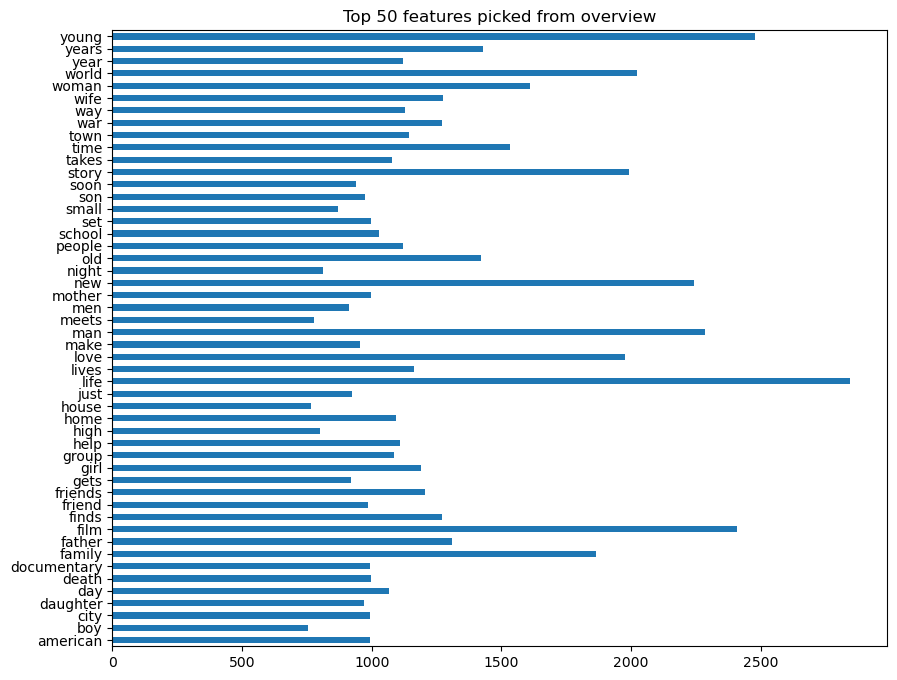

In [89]:
select_features_array.sum().plot(kind="barh", figsize=(10,8), title="Top 50 features picked from overview")

In [112]:
select_features_oh = select_features_array.apply(lambda x: pd.cut(x, bins=[-float('inf'), 0, float('inf')], labels=[0, 1]))

In [91]:
select_features_oh.head(1)

,american,boy,city,daughter,day,death,documentary,family,father,film,...,time,town,war,way,wife,woman,world,year,years,young
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [92]:
# Extract relevant features from the release date
movies_metadata['release_year'] = movies_metadata['release_date'].dt.year
movies_metadata['release_month'] = movies_metadata['release_date'].dt.month
movies_metadata['release_day'] = movies_metadata['release_date'].dt.day

In [93]:
movies_metadata_cols_keep = [
    "id",
    "adult",
    "budget",
    "original_language",
    "release_year",
    "release_month",
    "release_day",
    "revenue",
    "runtime",
    "status",
    "video",
    "vote_average",
]

In [94]:
movie_genre_oh.head(1)

,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Comedy,Genre_Crime,Genre_Documentary,Genre_Drama,Genre_Family,Genre_Fantasy,Genre_Foreign,Genre_History,Genre_Horror,Genre_Music,Genre_Mystery,Genre_Romance,Genre_Science Fiction,Genre_TV Movie,Genre_Thriller,Genre_War,Genre_Western
0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [95]:
movies_metadata[movies_metadata_cols_keep]["id"].isna().sum()

0

In [96]:
movies_metadata_final = pd.concat(
    [
        movies_metadata[movies_metadata_cols_keep].reset_index(drop=True),
        select_features_oh.reset_index(drop=True),
        num_spoken_lang.reset_index(drop=True),
        movie_genre_oh.reset_index(drop=True),
    ],
    axis=1,
)

In [97]:
movies_metadata_final.shape

(43369, 83)

# Merging everything together

In [98]:
print(movies_metadata_final.shape)
print(final_keywords_df.shape)
print(credits_final.shape)

(43369, 83)
(46419, 22)
(45476, 17)


In [99]:
final_df = movies_metadata_final.merge(credits_final, on="id", how="inner")

In [100]:
final_df.shape

(43405, 99)

In [101]:
final_df = final_df.merge(credits_final, on="id", how="inner")

In [102]:
final_df.shape

(43479, 115)

In [103]:
final_df.loc[:,final_df.isna().any().values].isna().sum()

original_language     11
release_year          84
release_month         84
release_day           84
revenue                2
runtime              251
status                78
video                  2
vote_average           2
dtype: int64

In [104]:
# For convenience lets just drop the NAs (they are very few)
final_df.dropna().shape

(43075, 115)

In [105]:
final_df = final_df.dropna().drop(columns=["id"])

In [106]:
final_df.to_pickle("training_data.pickle")
# Training will be done inside /training.ipynb

#### Load files for manual investigation

In [107]:
# utility_functions.dump_corpus_in_chunks(corpus=keywords["keywords"], ids=keywords["id"], file_path="keywords.txt",chunks=6)

In [108]:
# TODO create column that counts the length of the overview, maybe a longer overview shows that the movie has a more appealing description

The target variable will be vote_average, this variable also based on my research is built using some of the other variables available in the dataset: https://help.imdb.com/article/imdb/track-movies-tv/weighted-average-ratings/GWT2DSBYVT2F25SK# . Given how much data is missing from ratings.csv, it will not be very practical to try to recalculate vote_average. 

For pratical reasons I will not analyze or use all the features in the datasets, given that the preprocessing part took so long
I will first use a script that I have to grid search the "best" algorithm. Please note the grid will not be exhaustive or optimized.

The feature space also has been  be reduced significantly and training will be done only using a sparse matrix, the sparse matrix here is used to show how the problem should be handled in a production environment. 

Some features will also be omitted from the analysis that can cause data leakage or will not be available during PROD, e.g., vote_count.
vote_count in particular will cause data leakage because it allows for the calculation of the target variable of average votes.

There is a lot more work that needs to be done before running any of the ML models:
- Additional preprocessing. 
- Usage of APIs to try to refresh some of the data that is missing/old in the dataset, this is possible thanks to the links.csv dataset and the URLs.
- Use the image URLs inside the links.csv file, if every movie has a poster associated with some link this would allow us to download the posters. Then those posters could have some of its features extracted that will be relevant for the forecast of vote_average (or some other target variable like revenue or budget).
- Try to update rows that have no budget for example, this is very unusual, 0 budget movies are in my opinion the same as non attributed data
- TF-IDF and CountVectorizer were the two sklearn functions that I used to do the NLP part of the project, but there are so many more options, Latent Semantic Analysis (LSA) to reduce the dimensionality of the textual data, topic modelling with LDA... 
- Potentially build a recommendation engine for movies.

The dataset in general has just too many missing values and incomplete data: 
- Revenue (where it is either 0 or NA), only 20% of the Revenue is really listed
- Budget is mostly equal to 0 
- vote_average is 0 inflated, here again most likely the 0 is just the data missing
- Even tho there are votes that are NA which could be interesting for prediction purposes, often all the other values are NAs for that given row making it no longer an interesting target. 

REMARK: I spent quite a bit of time processing the JSONs so they can be loaded with json.loads, all the JSONs almost are malformed with keywords.csv being very difficult to process

In [109]:
# TODO: analyze also the distribution of ratings based on vote_count, is 0 vote_count an error?
# Or is it normal if the reviewer was someone employed by certain company to do it a form of peer movie review,
# that is done by professions rather than by the general public? 

# NOTE: The data preprocessing done here is limited, it will take me a very long time to clean up all the data, I am just showcasing a few 
# data preprocessing techniques here. 

In [110]:
# poster_path and other variables that send you to another resoruce are interesting and can be used to update the data in the dataset
# using some form of potentially free API requests, given this is too long to implement and is a bit out of scope for this 
# ,since I will be leaving this dataset and will start gathering data from outside.
# poster_path also could let us use some image extraction